In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import pyfinancialdata
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation

Using TensorFlow backend.


## Model and settings

In [2]:
units = 25
epoch = 20
model_name = 'LSTM'

# Train on last 500 prices and try to predict the next price
look_back = 500
time_ahead = 1

# Create the model
model = Sequential()
model.add(LSTM(units, input_shape=(1, look_back)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

## Train and test data: GBP USD exchange rate, 2006-2017

In [3]:
train_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

test_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

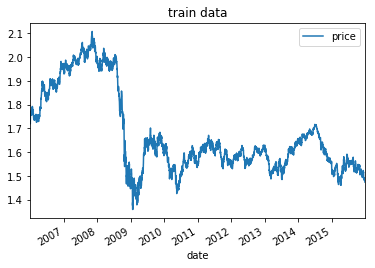

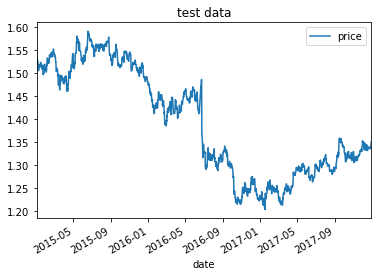

In [4]:
train_data.plot(title='train data')
test_data.plot(title='test data')

In [4]:
def create_training_dataset(dataset, look_back, time_ahead):
    '''
    Converts an array of values into a dataset matrix of X and Y for a sequential model
    '''
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back - time_ahead + 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back + time_ahead - 1, 0])

    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    dataY = np.array(dataY)

    return dataX, dataY

In [5]:
# Create dataset from the DataFrame and normalise
dataset = train_data['price'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# Create X, Y for training
trainX, trainY = create_training_dataset(dataset, look_back=look_back, time_ahead=time_ahead)

## Train the model

In [6]:
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




## Test the model

In [7]:
# a function to scale and predict
def predict(values):
    values = values.reshape(-1, 1)
    # Create and fit scaler
    local_scaler = MinMaxScaler(feature_range=(0, 1))
    local_scaler.fit(values)
    values = local_scaler.transform(values)
    values = np.reshape(values, (1, 1, look_back))
    prediction = model.predict(values)
    prediction = prediction.reshape(-1, 1)
    return local_scaler.inverse_transform(prediction)

In [8]:
# Put predictions from model into the dataframe with the test prices
test_data['prediction_next'] = test_data['price'].rolling(window=look_back).apply(predict, raw=True)
test_data['prediction'] = test_data['prediction_next'].shift(time_ahead)
test_data.dropna(subset=['prediction_next'], inplace=True)

In [9]:
# RMSE
rmse = np.sqrt(
    mean_squared_error(
        y_true=test_data.dropna()['price'].values,
        y_pred=test_data.dropna()['prediction'].values
    )
)
print('RMSE: {0}'.format(rmse))

RMSE: 0.01674455647048089


In [10]:
# add columns for price direction and predicted direction
test_data['next_direction'] = np.where(test_data['price'] > test_data['price'].shift(-1), -1, 1)
test_data['next_direction_prediction'] = np.where(test_data['prediction_next'] > test_data['price'], 1, -1)
test_data['correct'] = test_data['next_direction_prediction'] == test_data['next_direction']

## Results

In [11]:
# How often does the model predict the correct price change direction
test_data['correct'].value_counts()

True     612
False    598
Name: correct, dtype: int64

In [12]:
# Create trades from predictions
positions = pd.DataFrame()
positions['price'] = test_data['price']
positions['high'] = test_data['high']
positions['low'] = test_data['low']
positions['position'] = np.where(test_data['prediction_next'] > test_data['price'], 1, -1)
positions['position_group'] = (positions['position'].diff(1) != 0).astype('int').cumsum()
positions['position_group_shifted'] = positions['position_group'].shift(1)

In [13]:
trades = pd.DataFrame({
        'enter_date': positions.reset_index().groupby('position_group').date.first(),
        'enter_price': positions.reset_index().groupby('position_group')['price'].first(),
        'in_position_price_min': positions.reset_index().groupby('position_group_shifted')['low'].min(),
        'in_position_price_max': positions.reset_index().groupby('position_group_shifted')['high'].max(),
        'exit_date': positions.reset_index().groupby('position_group_shifted').date.last(),
        'exit_price': positions.reset_index().groupby('position_group_shifted')['price'].last(),
        'position_length': positions.groupby('position_group').size(),
        'position': positions.groupby('position_group')['position'].first(),
    }).reset_index(drop=True)

trades['profit'] = ((trades['exit_price'] - trades['enter_price']) * trades['position'])
trades['profitable'] = trades['profit'] > 0

In [14]:
# How often are the trades profitable?
trades['profitable'].value_counts()

True     82
False    33
Name: profitable, dtype: int64

In [15]:
print('Profitability: {0}%'.format(
    round(len(trades.loc[trades['profitable'] == True]) / len(trades) * 100)
))

Profitability: 71%
